In [1]:
%env CUDA_VISIBLE_DEVICES=3
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torch.nn as nn
import torchvision.transforms as transforms
import torchio

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=3


In [2]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)

        return mask

In [3]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(2 * nc, 4), dpi=100, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))

def dice_loss(true, logits, eps=1e-11):
    logits = logits.movedim(1,2).reshape(-1,4,240,240)
    true = true.movedim(1,2).reshape(-1,1,240,240)
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    # WT
    true_1_hot = ((true==1) | (true==2) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==2) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # ET
    true_1_hot = ((true==1) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # TC
    true_1_hot = ((true==1)).float().flatten()
    pred_1_hot = ((pmask==1)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls

def train_sampling_pattern(train_generator, model, n=16, verbose=True):
    w = torch.zeros(4,240).cuda().float()
    w[:,120] = 1
    w_list = []
    bbatch_size = 110
    for count in range(n):
        w = torch.autograd.Variable(w, requires_grad=True)
        pbar = tqdm(enumerate(train_generator), total=len(train_generator), leave=False, disable=not verbose)
        for I, (mask, img, mean, std) in pbar:
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * w.unsqueeze(1).unsqueeze(0).unsqueeze(-1)).abs() - mean) / (std + 1e-11)
            pred = model(img)
            loss = dice_loss(mask, pred)
            if torch.isnan(loss):
                print('warn')
                continue
            loss.backward()
        w_grad = w.grad.cpu().detach()
        w = w.detach()
        for j in range(4):
            for i in torch.topk(w_grad[j,:], 240, largest=False).indices:
                if w[j,i] == 0: 
                    w[j,i] = 1.
                    pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                    break
        w_list.append(w.clone())
        w = torch.autograd.Variable(w, requires_grad=True)
    return w_list

def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    with torch.no_grad():
        for mask, img, mean, std in tqdm(val_generator):
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            pred = model(img)
            dice_scores.append(1 - dice_loss(mask, pred).item())
    return dice_scores

def test_3d_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            img = (IFt(Ft(img * std + mean) * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            logits = model(img.cuda().float().unsqueeze(0))[0]
            dice_scores.append(np.mean(dice_coeff_3d_classes(mask, logits)))
    return dice_scores

def test_3d_on_classes_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            img = (IFt(Ft(img * std + mean) * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            logits = model(img.cuda().float().unsqueeze(0))[0]
            dice_scores.append(dice_coeff_3d_classes(mask, logits))
    return dice_scores


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        if indexes is not None:
            self.indexes = [str(i) for i in indexes]
        else:
            self.indexes = [k for k in self.hf.keys()]

    def __len__(self) -> int:
        return len(self.indexes)
    
    def __getitem__(self, item: int):
        key = self.indexes[item]
        img = self.hf[key][:-1,:,:,:]
        mask = self.hf[key][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std


class BraTS2dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug1=None, aug2=None, slices=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug1 = aug1
        self.aug2 = aug2
        if slices:
            self.slices = slices
        else:
            self.slices = []
            for k in tqdm(self.hf.keys()):
                for j in range(self.hf[k].shape[-1]):
                    if self.hf[k][:,:,:,j].max() != 0.:
                        self.slices.append((k, j))
        if indexes is not None:
            self.slices = [s for s in self.slices if int(s[0]) in indexes]

    def __len__(self) -> int:
        return len(self.slices)
    
    def __getitem__(self, item: int):
        key, idx = self.slices[item]
        img = self.hf[key][:-1,:,:,idx]
        mask = self.hf[key][-1:,:,:,idx]
        mask[mask==4] = 3
        if self.aug1:
            aug = self.aug1(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        if self.aug2:
            img = self.aug2(img.unsqueeze(0))[0]
        mask = torch.tensor(mask).long()
        mean = img.mean().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        std = img.std().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        img = (img - mean) / (std + 1e-11) + 1e-11
        return mask, img, mean, std

In [4]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [5]:
import pytorch_lightning as pl
from collections import OrderedDict

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model.load_state_dict(torch.load('unet3d-brats.pt'))
for p in model.parameters(): p.requires_grad = False
    
train_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')

In [6]:
len(train_3d_dataset), len(val_3d_dataset)

(258, 111)

# 5-fold validation x16 3D dice

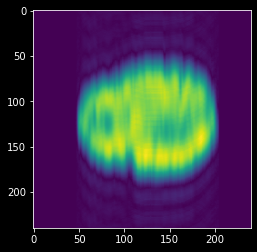

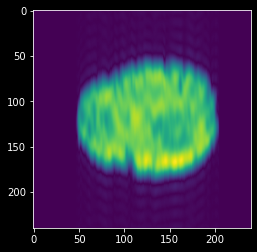

In [7]:
import contextlib
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    td = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=1, shuffle=True)
#     with contextlib.redirect_stdout(None):
#         w_list = train_sampling_pattern(tg, model, n=15, verbose=False)
    dice_fold_scores[i] = dict(
#         ours=test_3d_  sampling_pattern(w_list[14].unsqueeze(2).unsqueeze(1), model, vd),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, vd), 
        center=test_3d_sampling_pattern(zm, model, vd),
    )
    break

In [9]:
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('unet_fold_scores.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

In [10]:
with open('unet_fold_scores.pkl', 'rb') as f: fold_scores = pickle.load(f)

In [11]:
import scipy

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=0.8475181443395768, pvalue=0.44443992793465853)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.542555,0.604441,0.602340
std,0.008468,0.008059,0.009539
min,0.531477,0.593964,0.586833
25%,0.539147,0.597706,0.601656
50%,0.541136,0.608870,0.603827
75%,0.547047,0.609556,0.607165
max,0.553970,0.612112,0.612217


# Train of full train

In [9]:
tg = torch.utils.data.DataLoader(train_3d_dataset, batch_size=1)
w = train_sampling_pattern(tg, model, n=15)[14]
torch.save(w, 'sampling_igs.pt')

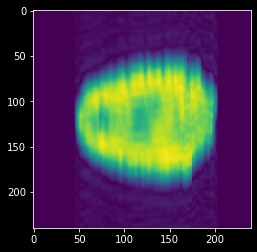

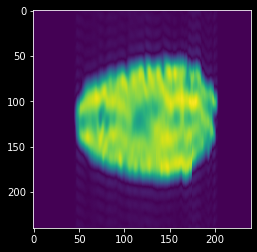

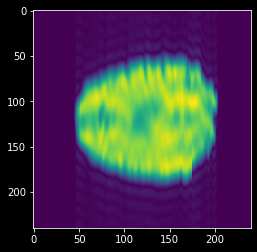

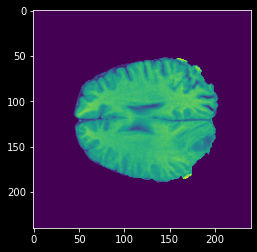

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()
w = torch.load('sampling_igs.pt')

dice_scores = dict(
    fastmri=test_3d_on_classes_sampling_pattern(fastmri_mask_x16, model, val_3d_dataset), 
    center=test_3d_on_classes_sampling_pattern(zm, model, val_3d_dataset),
    ours=test_3d_on_classes_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model, val_3d_dataset),
    full=test_3d_on_classes_sampling_pattern(fm, model, val_3d_dataset)
)

In [8]:
class_map = {0: 'WT', 1: 'ET', 2: 'TC'}
for name in dice_scores.keys():
    arr = np.array(dice_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.651132    0.524379    0.275420
std      0.208866    0.269476    0.268498
min      0.092207    0.000000    0.000000
25%      0.538550    0.314361    0.017234
50%      0.712299    0.604473    0.168446
75%      0.820269    0.747801    0.508585
max      0.911077    0.865427    0.843582
############## center ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.681968    0.581517    0.342607
std      0.226616    0.276492    0.290076
min      0.075929    0.000000    0.000000
25%      0.557655    0.370479    0.033265
50%      0.761234    0.668006    0.278838
75%      0.865217    0.810102    0.608360
max      0.926169    0.890095    0.868563
############## ours ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.685168    0.570888    0.333727
std     

In [10]:
sum([np.prod(p.size()) for p in model.parameters()])

5652532

In [9]:
mask, img, mean, std = val_3d_dataset[1]
mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
ks = Ft(img * std + mean)
img = (IFt(ks * fm).abs() - mean) / (std + 1e-11)
pred = model(img.movedim(1,0)).movedim(1,0)
print(dice_coeff_3d_classes(mask, pred))
probas = torch.nn.functional.softmax(pred, dim=0)
probas[probas > 0.5] = 1
probas[probas <= 0.5] = 0
pmask = torch.zeros_like(mask).float()
for i in range(1, 4): pmask[0] += probas[i] * i

[0.9576348662376404, 0.502840518951416, 0.46984678506851196]


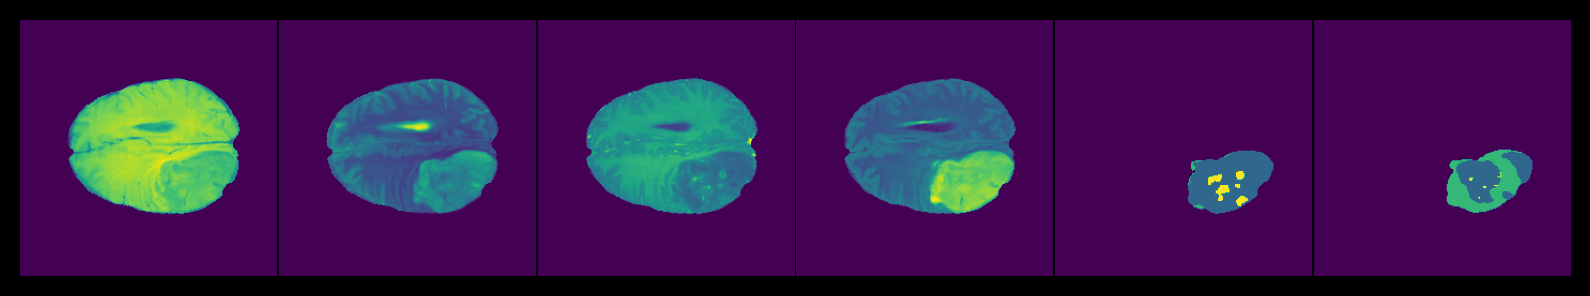

In [10]:
z = 100
fig, ax = plt.subplots(figsize=(10,10), ncols=6, dpi=200,
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]),
                       gridspec_kw=dict(wspace=0.01, hspace=0.0))
ax[0].imshow(img[0,z].cpu())
ax[1].imshow(img[1,z].cpu())
ax[2].imshow(img[2,z].cpu())
ax[3].imshow(img[3,z].cpu())
ax[4].imshow(mask[0,z].cpu())
ax[5].imshow(pmask[0,z].cpu())
plt.show()